In [132]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ete3 import NCBITaxa
from tqdm.notebook import tqdm
from Bio import SeqIO
import re
import gzip


In [2]:
os.chdir('/master/nplatt/patho_detect/')

with open('data/19047-23/samples.list') as infile:
    samples = infile.read().splitlines()

# Create a database from kraken files

## combine raw kraken output

In [ ]:
kraken_csvs=glob.glob('results/kraken2/*csv')

kraken_columns=["root_perc_frags", "root_num_frags", "taxon_num_frags", "rank", "ncbi_taxa_id", "sci_name"]

df=pd.DataFrame()

for csv in kraken_csvs:
    
    #get sample name
    sample=csv.split("_")[0].split("/")[-1]
    #open file
    sub_df=pd.read_csv(csv, names=kraken_columns, sep=",", header=None)
    
    #add sample info
    sub_df["sample"]=sample
    
    #add to larger pandas df
    df=pd.concat([df, sub_df])

## generate an ncbi taxonomy

In [49]:
ncbi = NCBITaxa()
#ncbi.update_taxonomy_database()

NCBI database format is outdated. Upgrading
Local taxdump.tar.gz seems up-to-date


Loading node names...
2312412 names loaded.
242402 synonyms loaded.
Loading nodes...
2312412 nodes loaded.
Linking nodes...
Tree is loaded.
Updating database: /master/nplatt/.etetoolkit/taxa.sqlite ...
 2312000 generating entries... 
Uploading to /master/nplatt/.etetoolkit/taxa.sqlite


Inserting synonyms:      15000 

Inserting synonyms:      240000 

Inserting taxids:       10000  

Inserting taxids:       2310000 

## add taxon rank info to each kraken entry

In [5]:
#get all ncbi taxanomic ranks:
lineages=[]
uniq_taxa=df["ncbi_taxa_id"].unique()

ranks=set()

for taxon in uniq_taxa:
    try:
        lineage = ncbi.get_lineage(taxon)
        ranks= ranks | set(ncbi.get_rank(lineage).values())
    except:
        continue
        
ranks

/master/nplatt/miniconda3/envs/patho_detect-jupyter/lib/python3.6/site-packages/ete3-3.1.2-py3.7.egg/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 46170 was translated into 1280
/master/nplatt/miniconda3/envs/patho_detect-jupyter/lib/python3.6/site-packages/ete3-3.1.2-py3.7.egg/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 2005363 was translated into 1955413
/master/nplatt/miniconda3/envs/patho_detect-jupyter/lib/python3.6/site-packages/ete3-3.1.2-py3.7.egg/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 1849491 was translated into 1817405
/master/nplatt/miniconda3/envs/patho_detect-jupyter/lib/python3.6/site-packages/ete3-3.1.2-py3.7.egg/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 1935188 was translated into 2082587
/master/nplatt/miniconda3/envs/patho_detect-jupyter/lib/python3.6/site-packages/ete3-3.1.2-py3.7.egg/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 2202142 was translated into 2202141
/master/nplatt/miniconda3/envs/patho_det

{'biotype',
 'clade',
 'class',
 'family',
 'forma specialis',
 'genus',
 'infraorder',
 'isolate',
 'kingdom',
 'no rank',
 'order',
 'parvorder',
 'pathogroup',
 'phylum',
 'section',
 'serogroup',
 'serotype',
 'species',
 'species group',
 'species subgroup',
 'strain',
 'subclass',
 'subfamily',
 'subgenus',
 'subkingdom',
 'suborder',
 'subphylum',
 'subspecies',
 'superclass',
 'superfamily',
 'superkingdom',
 'superorder',
 'tribe',
 'varietas'}

In [7]:
#manually set major ranks (ex. care about phylum not serogroups)

major_ranks = [ "superkingdom", "kingdom", "phylum", "class", "order", "family", "genus", "species"]
 

for rank in major_ranks:
    df[rank] = np.nan


In [8]:
df

,root_perc_frags,root_num_frags,taxon_num_frags,rank,ncbi_taxa_id,sci_name,sample,lineage,superkingdom,kingdom,phylum,class,order,family,genus,species
0,3.51,272550,272550,U,0,unclassified,TK164714,unclassified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,96.49,7496114,2745,R,1,root,TK164714,root,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,96.36,7486260,6074,R1,131567,cellular organisms,TK164714,"root, cellular organisms",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,95.29,7402841,3951,D,2759,Eukaryota,TK164714,"root, Eukaryota, cellular organisms",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,95.13,7390397,4311,D1,33154,Opisthokonta,TK164714,"root, Eukaryota, Opisthokonta, cellular organisms",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
168283,0.00,1,0,G,393029,Desulfurispirillum,TK25656,"root, Bacteria, Chrysiogenetes, cellular organ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
168284,0.00,1,0,S,936456,Desulfurispirillum indicum,TK25656,"root, Bacteria, Chrysiogenetes, cellular organ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
168285,0.00,1,1,S1,653733,Desulfurispirillum indicum S5,TK25656,"root, Bacteria, Chrysiogenetes, cellular organ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
168286,0.40,54165,0,R1,2787854,other entries,TK25656,"root, other entries",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
#add the taxonomic name for each rank column (ex. for mammals class will be "mammalia"
#  should make it easier to sort

for index, row in tqdm(df.iterrows(), total=df.shape[0], desc="Entries added"):
    ncbi_id=row["ncbi_taxa_id"]
    try:
        lineage = ncbi.get_lineage(ncbi_id)
        taxids=ncbi.get_taxid_translator(lineage)
        ranks=ncbi.get_rank(lineage)

        for ncbi_taxa_id in taxids.keys():            
            tax=taxids[ncbi_taxa_id]
            rank=ranks[ncbi_taxa_id]
            if rank in df.columns:
                df.loc[index, rank]=tax
        
    except:
        continue    

Entries added:   0%|          | 0/168288 [00:00<?, ?it/s]

/master/nplatt/miniconda3/envs/patho_detect-jupyter/lib/python3.6/site-packages/ete3-3.1.2-py3.7.egg/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 46170 was translated into 1280
/master/nplatt/miniconda3/envs/patho_detect-jupyter/lib/python3.6/site-packages/ete3-3.1.2-py3.7.egg/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 2005363 was translated into 1955413
/master/nplatt/miniconda3/envs/patho_detect-jupyter/lib/python3.6/site-packages/ete3-3.1.2-py3.7.egg/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 1849491 was translated into 1817405
/master/nplatt/miniconda3/envs/patho_detect-jupyter/lib/python3.6/site-packages/ete3-3.1.2-py3.7.egg/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 1935188 was translated into 2082587
/master/nplatt/miniconda3/envs/patho_detect-jupyter/lib/python3.6/site-packages/ete3-3.1.2-py3.7.egg/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 2202142 was translated into 2202141
/master/nplatt/miniconda3/envs/patho_det

## save df to csv

In [11]:
df

,root_perc_frags,root_num_frags,taxon_num_frags,rank,ncbi_taxa_id,sci_name,sample,lineage,superkingdom,kingdom,phylum,class,order,family,genus,species
0,3.51,272550,272550,U,0,unclassified,TK164714,unclassified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,96.49,7496114,2745,R,1,root,TK164714,root,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,96.36,7486260,6074,R1,131567,cellular organisms,TK164714,"root, cellular organisms",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,95.29,7402841,3951,D,2759,Eukaryota,TK164714,"root, Eukaryota, cellular organisms",Eukaryota,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,95.13,7390397,4311,D1,33154,Opisthokonta,TK164714,"root, Eukaryota, Opisthokonta, cellular organisms",Eukaryota,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
168283,0.00,1,0,G,393029,Desulfurispirillum,TK25656,"root, Bacteria, Chrysiogenetes, cellular organ...",Bacteria,NaN,Chrysiogenetes,Chrysiogenetes,Chrysiogenales,Chrysiogenaceae,Desulfurispirillum,NaN
168284,0.00,1,0,S,936456,Desulfurispirillum indicum,TK25656,"root, Bacteria, Chrysiogenetes, cellular organ...",Bacteria,NaN,Chrysiogenetes,Chrysiogenetes,Chrysiogenales,Chrysiogenaceae,Desulfurispirillum,Desulfurispirillum indicum
168285,0.00,1,1,S1,653733,Desulfurispirillum indicum S5,TK25656,"root, Bacteria, Chrysiogenetes, cellular organ...",Bacteria,NaN,Chrysiogenetes,Chrysiogenetes,Chrysiogenales,Chrysiogenaceae,Desulfurispirillum,Desulfurispirillum indicum
168286,0.40,54165,0,R1,2787854,other entries,TK25656,"root, other entries",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
df.to_csv("results/python_analyses/kraken_wlineages.csv", sep=',', index=False, header=True)

# Analyze read class db

In [3]:
df=pd.read_csv("results/python_analyses/kraken_wlineages.csv", sep=',')

/master/nplatt/miniconda3/envs/patho_detect-jupyter/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2714: DtypeWarning: Columns (9) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## filter

In [299]:
num_reads_series=df.groupby(["sample"])["taxon_num_frags"].sum()


In [37]:
x_df = df.loc[(df["class"]=="Mammalia")].groupby(["sample"])

#x_df.first()
#x_df.get_group('Mouse2')
x_df["taxon_num_frags"].sum()/1_000_000

sample
Hamster1     4.983388
Hamster2     6.611205
Hamster3     1.386616
Hamster4    10.050688
Mouse2       7.641107
TK154677     2.022290
TK154685     7.334110
TK154687     8.619986
TK164536     3.737819
TK164565     2.374137
TK164566     6.016395
TK164573    18.946439
TK164677     3.088807
TK164683     6.024360
TK164684     4.708755
TK164686     6.574116
TK164688    10.968173
TK164689     7.108976
TK164690     6.804155
TK164691     7.359309
TK164702     4.529730
TK164703     7.740739
TK164704    10.123349
TK164705     2.767197
TK164706     7.096525
TK164709     1.889485
TK164710     2.196967
TK164712    10.145633
TK164713     4.631646
TK164714     7.347659
TK164715     1.699468
TK164716    13.660364
TK164717     2.597121
TK164721     6.332092
TK164724     3.640576
TK164728     5.734512
TK164729     3.742286
TK164730     4.697668
TK164731     7.858074
TK164732     7.694640
TK164736     7.747705
TK164740     3.725406
TK164843     6.107616
TK164844     5.837702
TK164845     3.273992
TK1

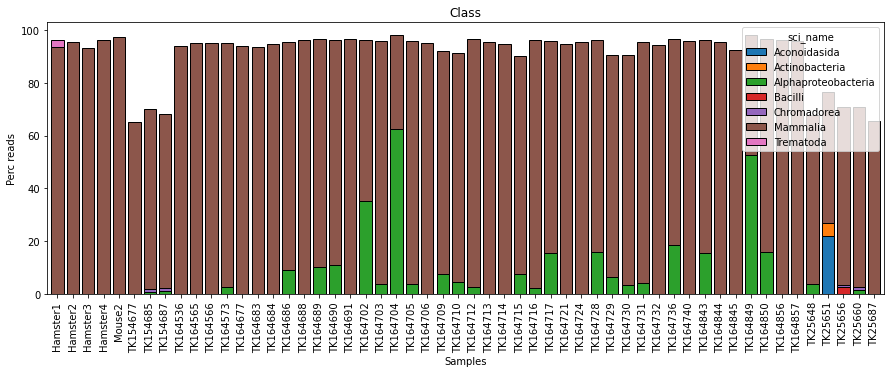

In [155]:
#df.loc[(df["rank"]=="G")].groupby(["sample"]).first()
class_gb=df.loc[(df["rank"]=="C") & (df["root_num_frags"]>100_000)].groupby(["sample", "sci_name"])["root_perc_frags"].sum().to_frame(name = 'sum').reset_index()

x_df=class_gb.pivot(index="sample", columns="sci_name", values="sum").fillna(0)
fig=x_df.plot(kind='bar', stacked=True, figsize=(15,5), title="Class", ylabel="Perc reads", xlabel="Samples", width=0.8, ec="black").get_figure()

#fig.savefig('class.svg')



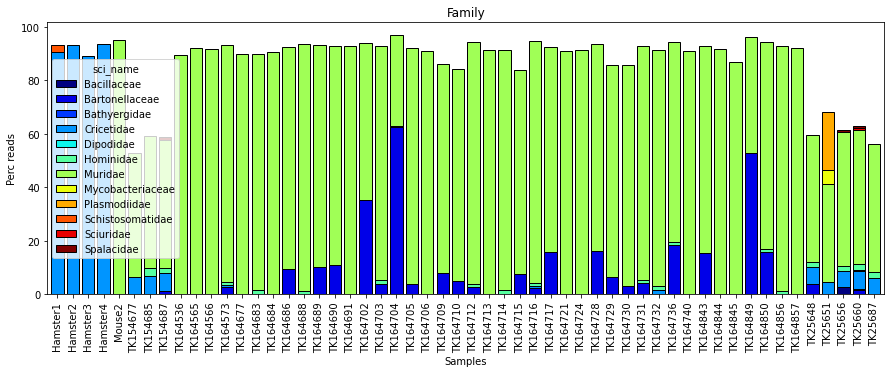

In [113]:
#df.loc[(df["rank"]=="G")].groupby(["sample"]).first()
fam_gb=df.loc[(df["rank"]=="F") & (df["root_num_frags"]>100_000)].groupby(["sample", "sci_name"])["root_perc_frags"].sum().to_frame(name = 'sum').reset_index()

x_df=fam_gb.pivot(index="sample", columns="sci_name", values="sum").fillna(0)
fig=x_df.plot(kind='bar', 
              stacked=True, 
              figsize=(15,5), 
              title="Family", 
              xlabel="Samples", 
              ylabel="Perc reads", 
              width=0.8, 
              ec="black", 
              colormap="jet").get_figure()
fig.savefig('fam.svg')



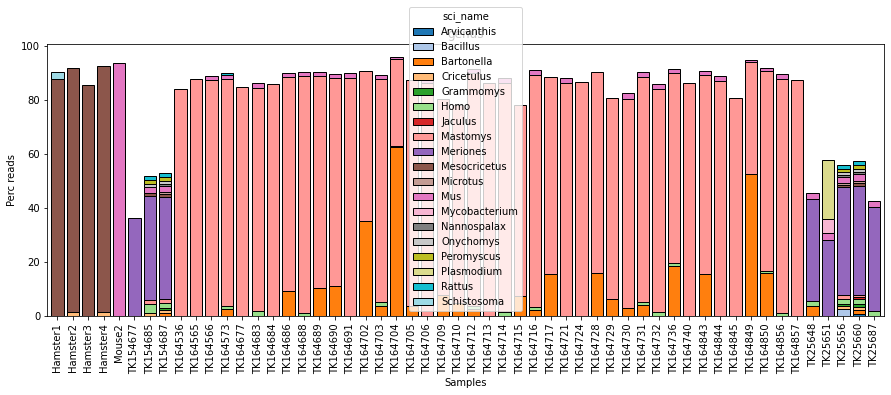

In [148]:
#df.loc[(df["rank"]=="G")].groupby(["sample"]).first()
genus_gb=df.loc[(df["rank"]=="G") & (df["root_num_frags"]>100_000)].groupby(["sample", "sci_name"])["root_perc_frags"].sum().to_frame(name = 'sum').reset_index()

x_df=genus_gb.pivot(index="sample", columns="sci_name", values="sum").fillna(0)
fig=x_df.plot(kind='bar', 
              stacked=True, 
              figsize=(15,5), 
              title="genus", 
              xlabel="Samples", 
              ylabel="Perc reads", 
              width=0.8, 
              ec="black",
              colormap="tab20").get_figure()
fig.savefig('genus.svg')



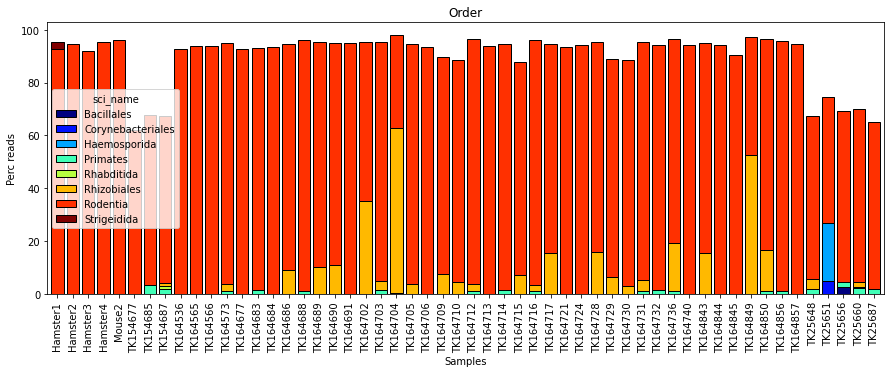

In [116]:
#df.loc[(df["rank"]=="G")].groupby(["sample"]).first()
order_gb=df.loc[(df["rank"]=="O") & (df["root_num_frags"]>100_000)].groupby(["sample", "sci_name"])["root_perc_frags"].sum().to_frame(name = 'sum').reset_index()

x_df=order_gb.pivot(index="sample", columns="sci_name", values="sum").fillna(0)
fig=x_df.plot(kind='bar', 
              stacked=True, 
              figsize=(15,5), 
              title="Order", 
              xlabel="Samples", 
              ylabel="Perc reads", 
              width=0.8, 
              ec="black",
              colormap="jet").get_figure()
fig.savefig('order.svg')



## heatmap

convert the indiv. read classification data to a single data frame that gives reads counts per taxon

In [444]:
num_frags_gb=df.loc[(df["rank"]=="F") & (df["root_num_frags"]>100)].groupby(["sample", "sci_name"])["root_num_frags"].sum().to_frame(name = 'sum').reset_index()

num_frags_df=num_frags_gb.pivot(index="sample", columns="sci_name", values="sum").fillna(0)

#add total num_reads
num_frags_df=num_frags_df.merge(num_reads_series.to_frame(), left_index=True, right_index=True)

#covert to percentages
num_frags_df=num_frags_df.div(x["taxon_num_frags"], axis=0)

Get a list of mammal, bacteria, and non-mammal eukaryotic pathogen names that can be used to remove columns in downstream data frames.

In [445]:
taxa = list(num_frags_df.columns)

taxa2id  = ncbi.get_name_translator(taxa)

cat2id = ncbi.get_name_translator(["Mammalia","Bacteria", "Eukaryota"])

mammal_names = []
bacteria_names = []
non_mam_euk_names = []

for taxon in tqdm(taxa2id.keys()):
    taxon_id = taxa2id[taxon]
    #get lineage
    lineage = ncbi.get_lineage(taxon_id[0])
    
    #is it a mammal
    if cat2id["Mammalia"][0] in lineage:
        mammal_names.append(taxon)
    #is it a bacteria
    elif cat2id["Bacteria"][0] in lineage:
        bacteria_names.append(taxon)
    #is it a eukaryote (but not a mammal)
    elif cat2id["Eukaryota"][0] in lineage:
        non_mam_euk_names.append(taxon)
    #something else
    else:
        print("what the crap is a {}".format(taxon))

  0%|          | 0/292 [00:00<?, ?it/s]

In [446]:
bacteria_df=num_frags_df[bacteria_names]
euk_path_df=num_frags_df[non_mam_euk_names]
mammal_df=num_frags_df[mammal_names]

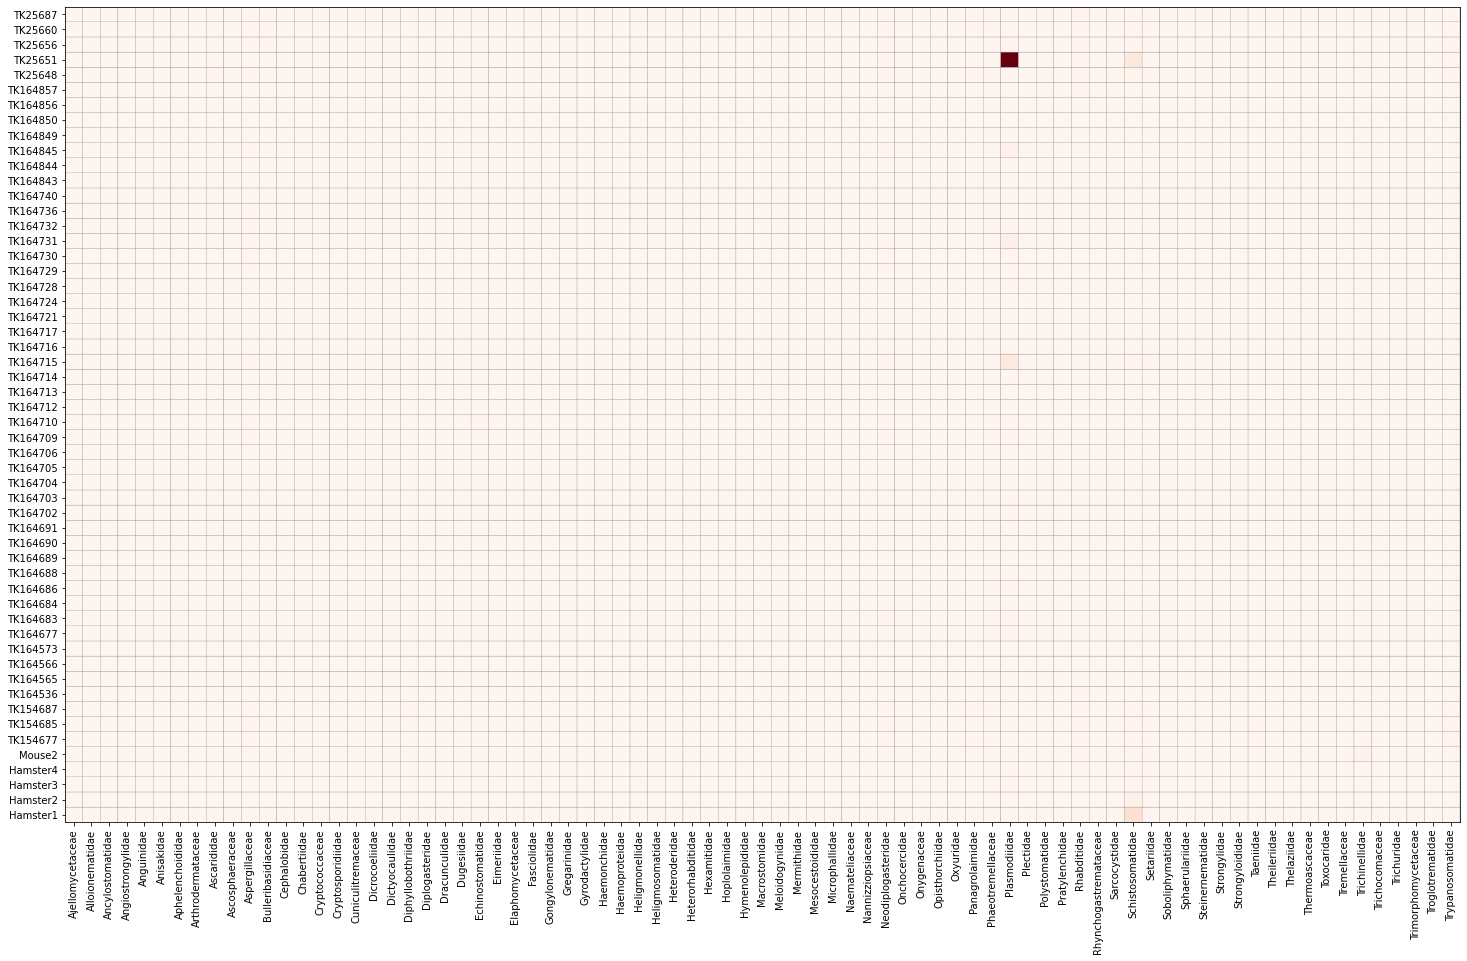

In [451]:
plt.figure(figsize=(25,15))
plt.pcolor(euk_path_df, cmap="Reds", edgecolor='grey')
plt.yticks(np.arange(0.5, len(euk_path_df.index), 1), euk_path_df.index)
plt.xticks(np.arange(0.5, len(euk_path_df.columns), 1), euk_path_df.columns, rotation='vertical')
plt.savefig('euk_paths_heatmap.png', dpi=300, facecolor="white")
plt.show()

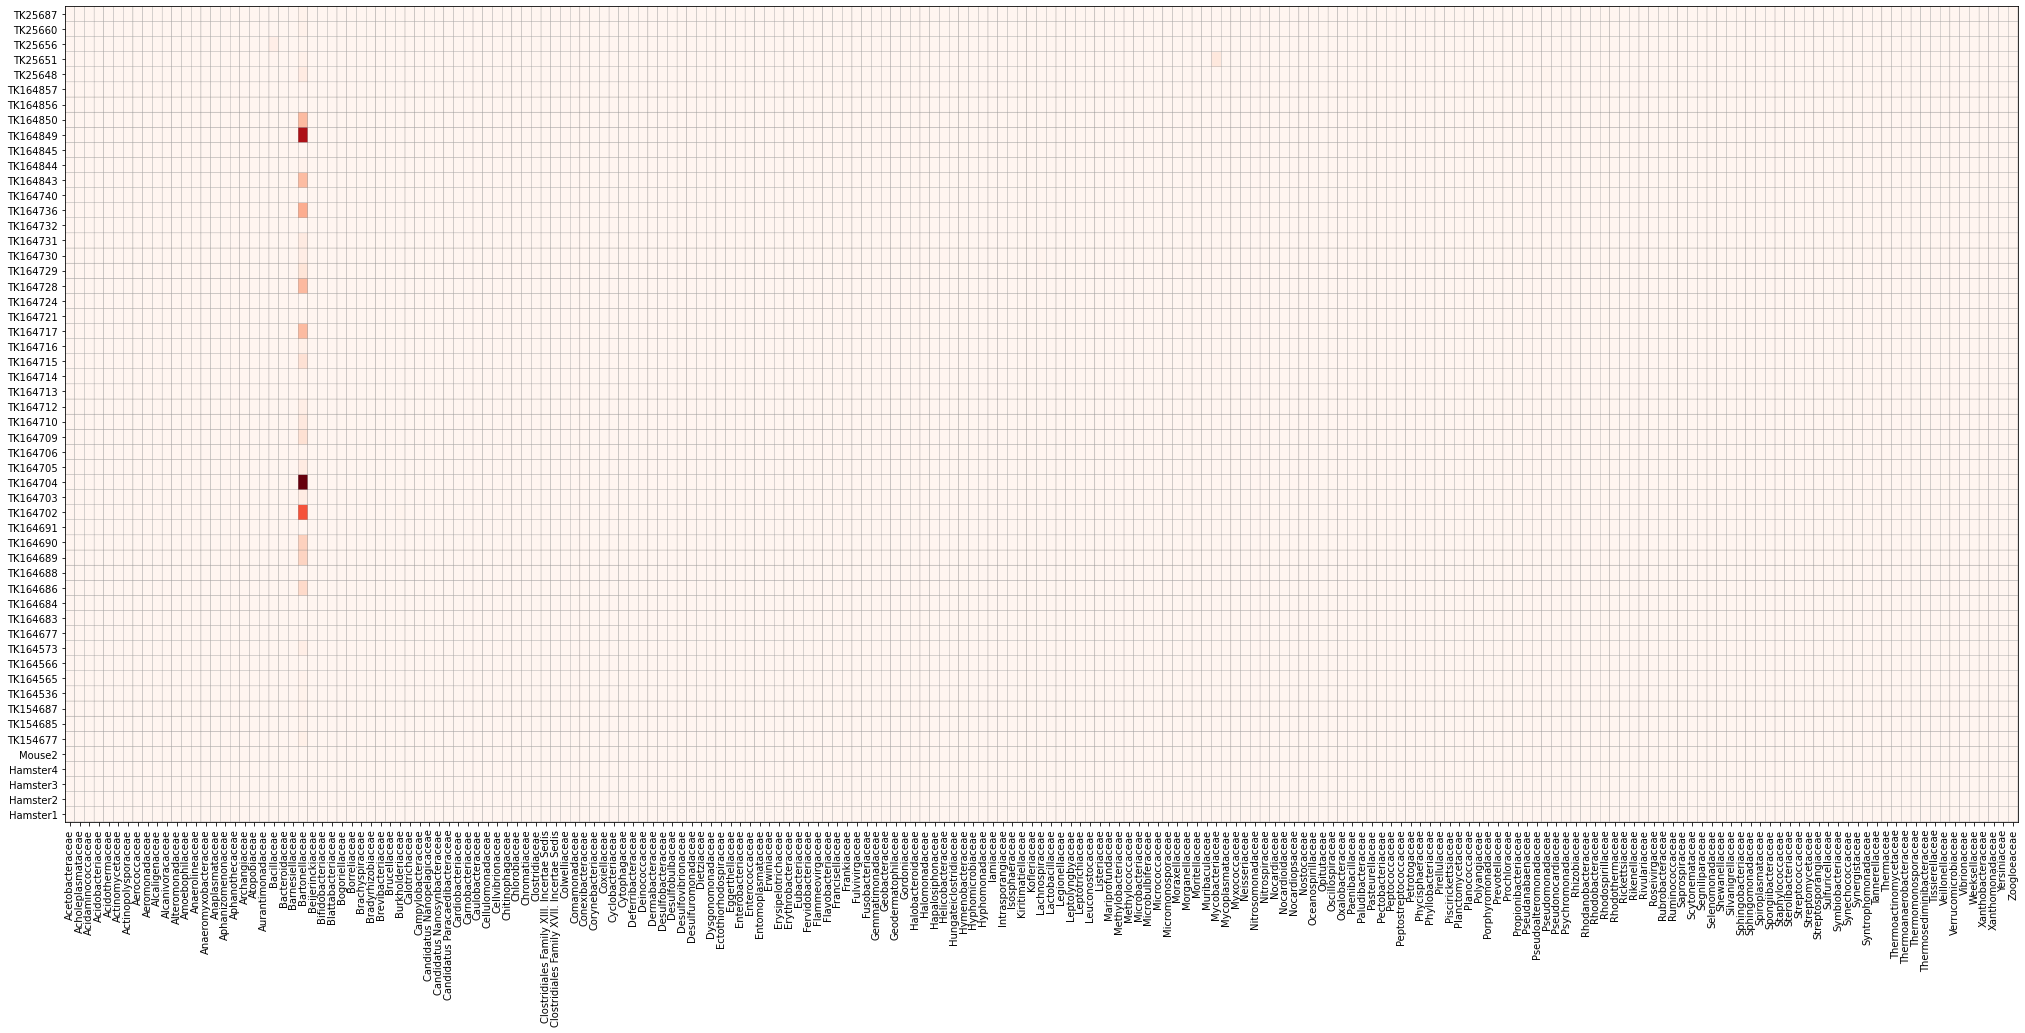

In [452]:
plt.figure(figsize=(35,15))
plt.pcolor(bacteria_df, cmap="Reds", edgecolor='grey')
plt.yticks(np.arange(0.5, len(bacteria_df.index), 1), bacteria_df.index)
plt.xticks(np.arange(0.5, len(bacteria_df.columns), 1), bacteria_df.columns, rotation='vertical')
plt.savefig('bacteria_heatmap.png', dpi=300, facecolor="white")
plt.show()

# Next

In [20]:
df.loc[(df["sample"]=="TK25651") & (df["genus"]=="Plasmodium")]


,root_perc_frags,root_num_frags,taxon_num_frags,rank,ncbi_taxa_id,sci_name,sample,lineage,superkingdom,kingdom,phylum,class,order,family,genus,species
103335,21.95,1028637,126,G,5820,Plasmodium,TK25651,"root, Eukaryota, Apicomplexa, Haemosporida, Pl...",Eukaryota,NaN,Apicomplexa,Aconoidasida,Haemosporida,Plasmodiidae,Plasmodium,NaN
103336,18.93,887345,542315,G1,418107,Plasmodium (Laverania),TK25651,"root, Eukaryota, Apicomplexa, Haemosporida, Pl...",Eukaryota,NaN,Apicomplexa,Aconoidasida,Haemosporida,Plasmodiidae,Plasmodium,NaN
103337,2.89,135526,0,S,5833,Plasmodium falciparum,TK25651,"root, Eukaryota, Apicomplexa, Haemosporida, Pl...",Eukaryota,NaN,Apicomplexa,Aconoidasida,Haemosporida,Plasmodiidae,Plasmodium,Plasmodium falciparum
103338,2.89,135526,135526,S1,36329,Plasmodium falciparum 3D7,TK25651,"root, Eukaryota, Apicomplexa, Haemosporida, Pl...",Eukaryota,NaN,Apicomplexa,Aconoidasida,Haemosporida,Plasmodiidae,Plasmodium,Plasmodium falciparum
103339,2.12,99408,99408,S,5854,Plasmodium reichenowi,TK25651,"root, Eukaryota, Apicomplexa, Haemosporida, Pl...",Eukaryota,NaN,Apicomplexa,Aconoidasida,Haemosporida,Plasmodiidae,Plasmodium,Plasmodium reichenowi
103340,0.96,44771,44771,S,880534,Plasmodium sp. gorilla clade G1,TK25651,"root, Eukaryota, Apicomplexa, Haemosporida, Pl...",Eukaryota,NaN,Apicomplexa,Aconoidasida,Haemosporida,Plasmodiidae,Plasmodium,Plasmodium sp. gorilla clade G1
103341,0.92,42988,42988,S,880536,Plasmodium sp. gorilla clade G3,TK25651,"root, Eukaryota, Apicomplexa, Haemosporida, Pl...",Eukaryota,NaN,Apicomplexa,Aconoidasida,Haemosporida,Plasmodiidae,Plasmodium,Plasmodium sp. gorilla clade G3
103342,0.48,22310,22310,S,880535,Plasmodium sp. gorilla clade G2,TK25651,"root, Eukaryota, Apicomplexa, Haemosporida, Pl...",Eukaryota,NaN,Apicomplexa,Aconoidasida,Haemosporida,Plasmodiidae,Plasmodium,Plasmodium sp. gorilla clade G2
103343,0.00,21,21,S,720590,Plasmodium sp. DRC-Itaito,TK25651,"root, Eukaryota, Apicomplexa, Haemosporida, Pl...",Eukaryota,NaN,Apicomplexa,Aconoidasida,Haemosporida,Plasmodiidae,Plasmodium,Plasmodium sp. DRC-Itaito
103344,0.00,6,6,S,647221,Plasmodium gaboni,TK25651,"root, Eukaryota, Apicomplexa, Haemosporida, Pl...",Eukaryota,NaN,Apicomplexa,Aconoidasida,Haemosporida,Plasmodiidae,Plasmodium,Plasmodium gaboni


In [130]:
sample = "TK25651_Exp5_42_P5"

r1_file="results/filter_reads/{}_filtered_R1_PE.fastq.gz".format(sample)
r2_file="results/filter_reads/{}_filtered_R2_PE.fastq.gz".format(sample)
results_tbl="results/kraken2/{}_kraken_results.tbl".format(sample)

#mammalia
target_taxa="Plasmodium"



In [122]:
#count number of lines for analyses
with open(results_tbl, 'r') as f:
    n_lines=len(f.readlines())
    
#
with open(results_tbl, 'r') as in_f:
    with open("outfile.txt", 'w') as out_f:
        for entry in tqdm(in_f, total=n_lines):
            if "Plasmodium" in entry:
                out_f.write("{}\n".format(entry.split("\t")[1]))

#extract with seqtk
! seqtk subseq results/filter_reads/TK25651_Exp5_42_P5_filtered_R1_PE.fastq.gz outfile.txt >test.fq


  0%|          | 0/4687054 [00:00<?, ?it/s]

In [142]:
with gzip.open(r1_file, "rt") as f:
    n_fq_seqs=len(f.readlines())/4
    
n_fq_seqs

4687054.0

In [157]:
target_reads=[]
r1_read_ids=read_ids
records=[]
with gzip.open(r1_file, "rt") as f:
    for record in tqdm(SeqIO.parse(f, "fastq"), total=n_fq_seqs):
        records.append(record)
        
        
        
#         if record.id in r1_read_ids:
#             target_reads.append(record)
#             r1_read_ids.remove(record.id)

  0%|          | 0/4687054.0 [00:00<?, ?it/s]

In [156]:
len(read_ids)

1026984

In [87]:
ncbi.get_taxid_translator([2])

{2: 'Bacteria'}

In [86]:
taxid

0

# Unused

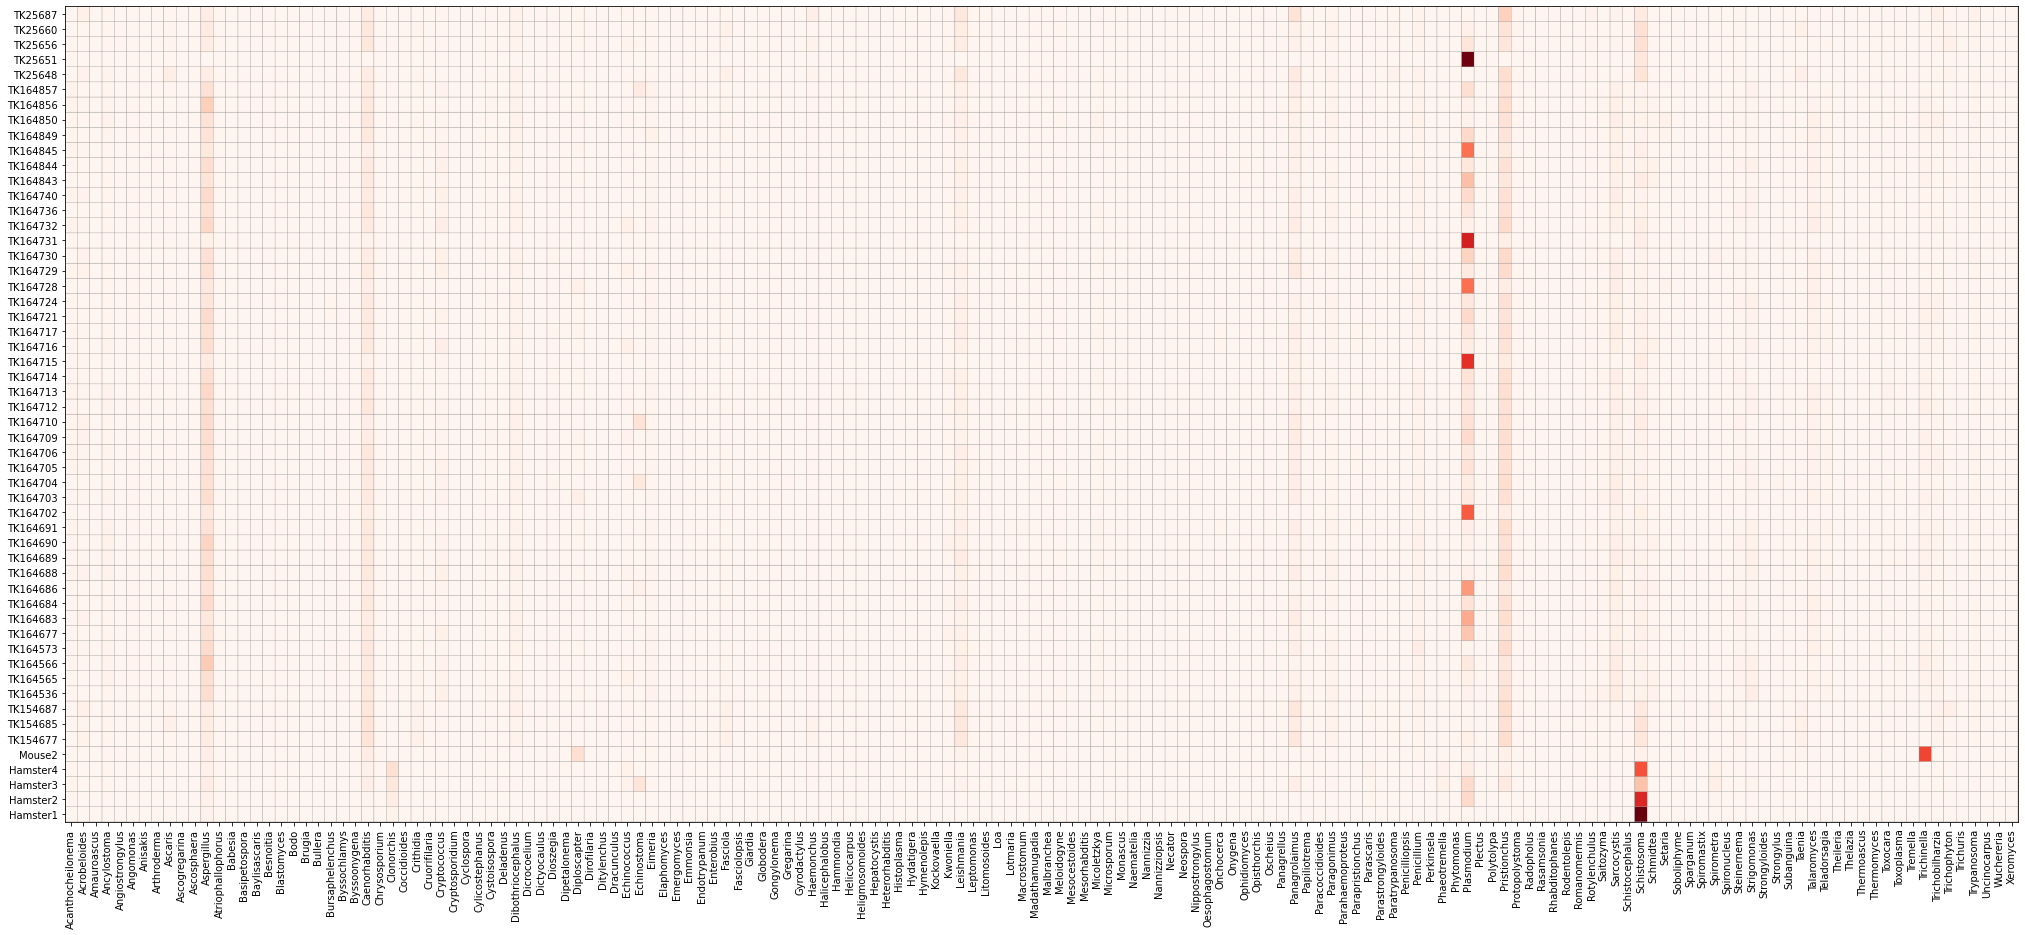

In [223]:


non_mammal_df = df.loc[(df["superkingdom"]=="Eukaryota") & (df["class"]!="Mammalia")]
genus_non_mammal_gb = non_mammal_df.loc[(df["rank"]=="G") & (df["root_num_frags"]>0)].groupby(["sample", "sci_name"])["root_num_frags"].sum().to_frame(name = 'sum').reset_index()

genus_non_mammal_df=genus_non_mammal_gb.pivot(index="sample", columns="sci_name", values="sum").fillna(0)
genus_non_mammal_df["sum"] = genus_non_mammal_df.sum(axis=1)
perc_genus_non_mammal_df=genus_non_mammal_df.div(genus_non_mammal_df["sum"]*100, axis=0)

perc_genus_non_mammal_df=perc_genus_non_mammal_df.drop(columns=["sum"])

plt.figure(figsize=(35,15))
plt.pcolor(perc_genus_non_mammal_df, cmap="Reds", edgecolor='grey')
plt.yticks(np.arange(0.5, len(perc_genus_non_mammal_df.index), 1), perc_genus_non_mammal_df.index)
plt.xticks(np.arange(0.5, len(perc_genus_non_mammal_df.columns), 1), perc_genus_non_mammal_df.columns, rotation='vertical')
plt.savefig('nonmam_euk_genus_gt_100_reads_heatmap.png', dpi=300, facecolor="white")
plt.show()

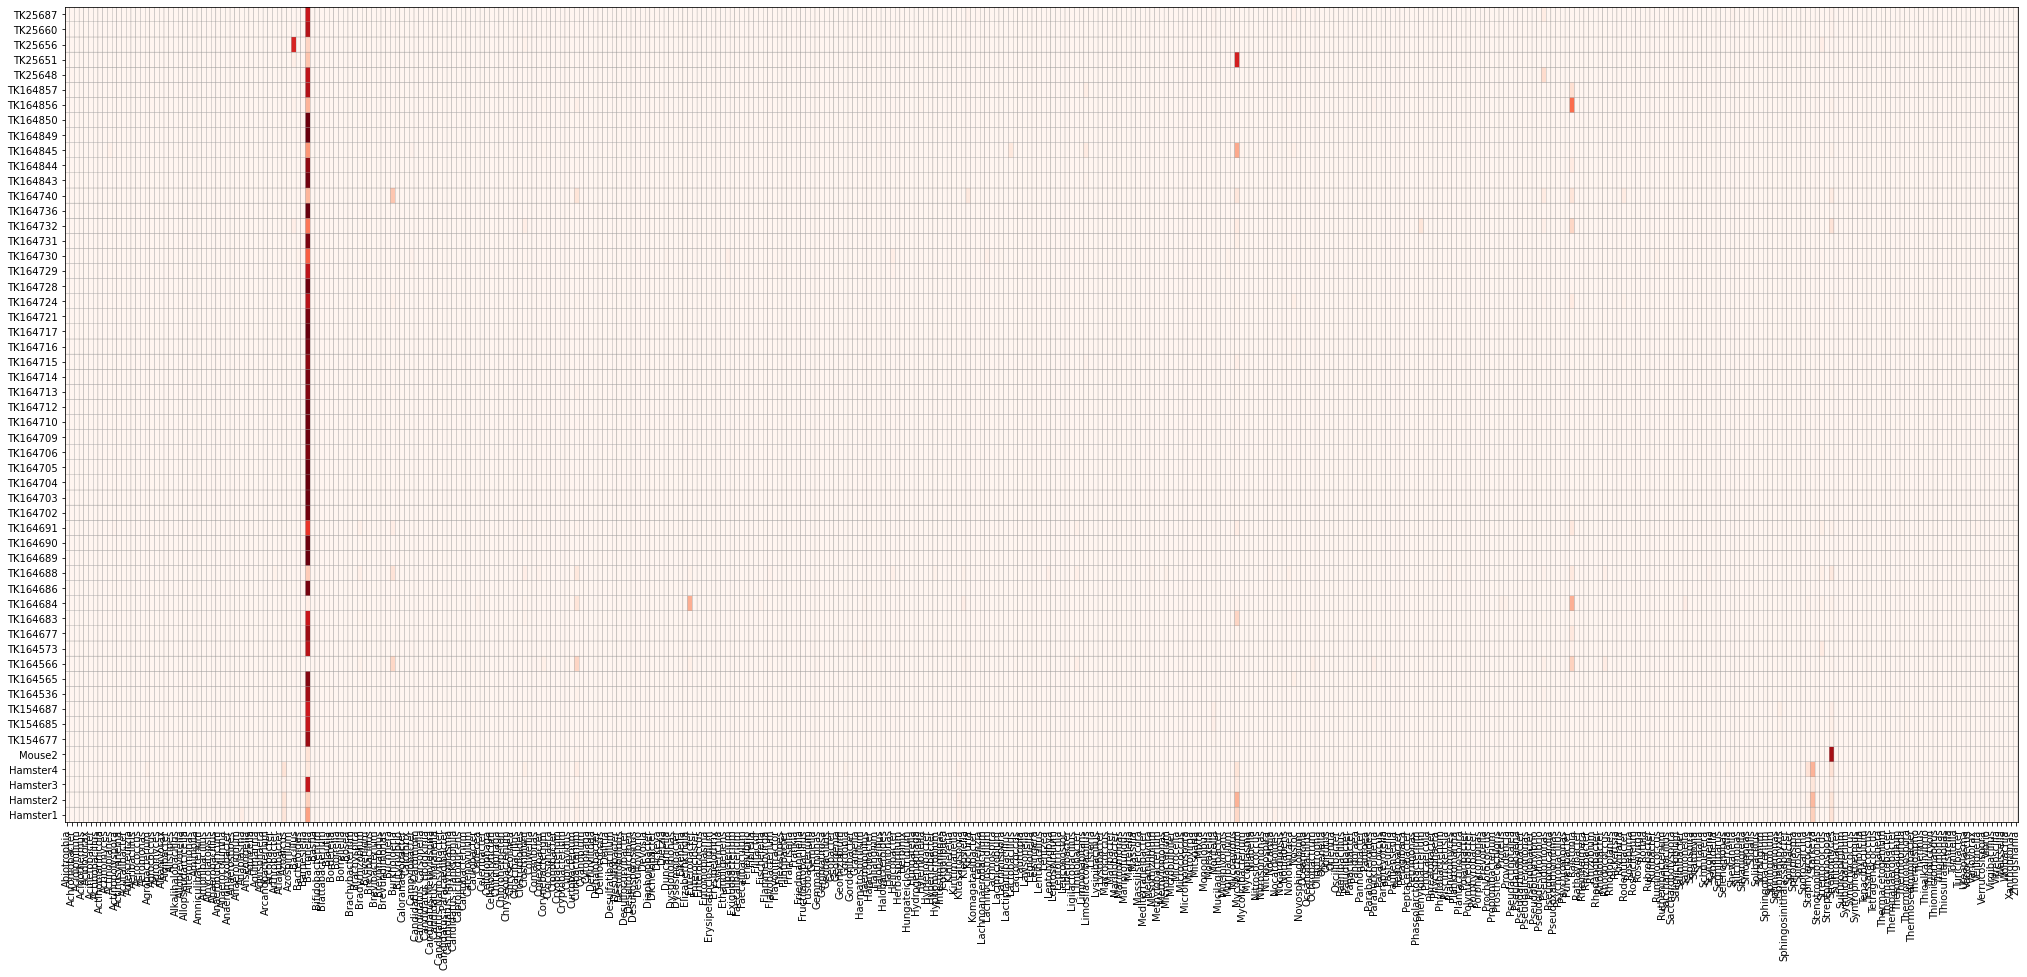

In [219]:
non_mammal_df = df.loc[df["superkingdom"]=="Bacteria"]
genus_non_mammal_gb = non_mammal_df.loc[(df["rank"]=="G") & (df["root_num_frags"]>100)].groupby(["sample", "sci_name"])["root_num_frags"].sum().to_frame(name = 'sum').reset_index()

genus_non_mammal_df=genus_non_mammal_gb.pivot(index="sample", columns="sci_name", values="sum").fillna(0)
genus_non_mammal_df["sum"] = genus_non_mammal_df.sum(axis=1)
perc_genus_non_mammal_df=genus_non_mammal_df.div(genus_non_mammal_df["sum"]*100, axis=0)

perc_genus_non_mammal_df=perc_genus_non_mammal_df.drop(columns=["sum"])

plt.figure(figsize=(35,15))
plt.pcolor(perc_genus_non_mammal_df, cmap="Reds", edgecolor='grey')
plt.yticks(np.arange(0.5, len(perc_genus_non_mammal_df.index), 1), perc_genus_non_mammal_df.index)
plt.xticks(np.arange(0.5, len(perc_genus_non_mammal_df.columns), 1), perc_genus_non_mammal_df.columns, rotation='vertical')
plt.savefig('bacteria_genus_gt_100_reads_heatmap.png', dpi=300, facecolor="white")
plt.show()

In [ ]:
non_mammal_df = df.loc[df["class"]=="Mammalia"]
genus_non_mammal_gb = non_mammal_df.loc[(df["rank"]=="F") & (df["root_num_frags"]>100)].groupby(["sample", "sci_name"])["root_num_frags"].sum().to_frame(name = 'sum').reset_index()

genus_non_mammal_df=genus_non_mammal_gb.pivot(index="sample", columns="sci_name", values="sum").fillna(0)
genus_non_mammal_df["sum"] = genus_non_mammal_df.sum(axis=1)
perc_genus_non_mammal_df=genus_non_mammal_df.div(genus_non_mammal_df["sum"]*100, axis=0)

perc_genus_non_mammal_df=perc_genus_non_mammal_df.drop(columns=["sum"])

plt.figure(figsize=(15,15))
plt.pcolor(perc_genus_non_mammal_df, cmap="Reds")
plt.yticks(np.arange(0.5, len(perc_genus_non_mammal_df.index), 1), perc_genus_non_mammal_df.index)
plt.xticks(np.arange(0.5, len(perc_genus_non_mammal_df.columns), 1), perc_genus_non_mammal_df.columns, rotation='vertical')
#plt.savefig('class_heatmap.png', dpi=300, facecolor="white")
plt.show()

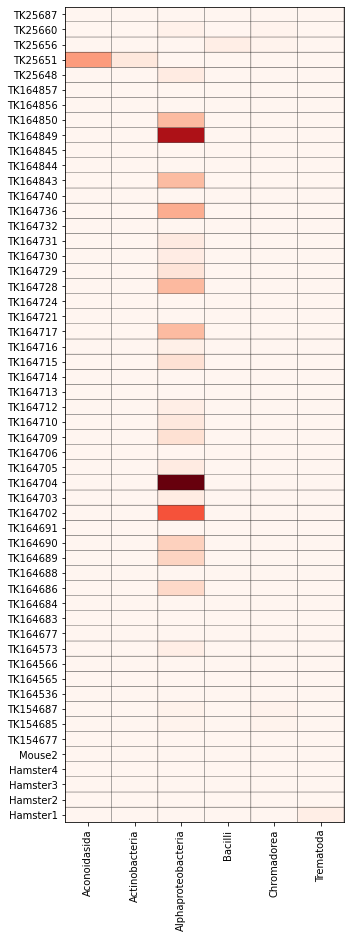

In [170]:
#index = ['aaa', 'bbb', 'ccc', 'ddd', 'eee']
#columns = ['A', 'B', 'C', 'D']
#df = DataFrame(abs(np.random.randn(5, 4)), index=index, columns=columns)

#x_df=x_df.drop(columns=["Mammalia"])
plt.figure(figsize=(5,15))
plt.pcolor(x_df, cmap="Reds",edgecolor='black')
plt.yticks(np.arange(0.5, len(x_df.index), 1), x_df.index)
plt.xticks(np.arange(0.5, len(x_df.columns), 1), x_df.columns, rotation='vertical')
plt.savefig('class_heatmap.png', dpi=300, facecolor="white")
plt.show()

/master/nplatt/miniconda3/envs/patho_detect-jupyter/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


-inf

(array([7., 1., 6., 3., 2., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 4., 0.,
        0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 1., 2.,
        1., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 4., 0., 1.,
        0., 2., 1., 3., 1., 0., 0., 0., 1., 3., 2., 6., 7., 9., 2.]),
 array([ 0.75  ,  1.7148,  2.6796,  3.6444,  4.6092,  5.574 ,  6.5388,
         7.5036,  8.4684,  9.4332, 10.398 , 11.3628, 12.3276, 13.2924,
        14.2572, 15.222 , 16.1868, 17.1516, 18.1164, 19.0812, 20.046 ,
        21.0108, 21.9756, 22.9404, 23.9052, 24.87  , 25.8348, 26.7996,
        27.7644, 28.7292, 29.694 , 30.6588, 31.6236, 32.5884, 33.5532,
        34.518 , 35.4828, 36.4476, 37.4124, 38.3772, 39.342 , 40.3068,
        41.2716, 42.2364, 43.2012, 44.166 , 45.1308, 46.0956, 47.0604,
        48.0252, 48.99  , 49.9548, 50.9196, 51.8844, 

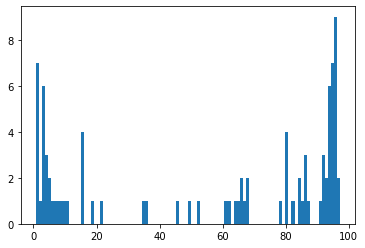

In [140]:
#x=x_df.stack().tolist()
#x=[float(x) for x in x]

#x_gt_0=[x for x in x if x >0.0]

plt.hist(x_gt_0, bins=100)

In [112]:
x_df.columns

Index(['Bacillales', 'Corynebacteriales', 'Haemosporida', 'Primates',
       'Rhabditida', 'Rhizobiales', 'Rodentia', 'Strigeidida'],
      dtype='object', name='sci_name')

In [105]:
df.loc[(df["order"]=="Strigeidida")]["genus"].unique()


array([nan, 'Schistosoma', 'Trichobilharzia'], dtype=object)

In [ ]:
genus_df=df.loc[(df["rank"]=="G") & (df["root_num_frags"]>100_000) & (df["root_perc_frags"]>1)]
genus_df["sci_name"].unique()

In [ ]:
#filtered_df=df.loc[(df["taxon_num_frags"]>100_000) & (df["root_perc_frags"]>1)]
#iltered_df

x_df=filt_df.groupby(["sample", "sci_name"])["root_perc_frags"].sum().to_frame(name = 'sum').reset_index()
y_df=x_df.pivot(index="sample", columns="sci_name", values="sum").fillna(0)
y_df
y_df.plot(kind='bar', stacked=True)

In [ ]:
df=df.loc[(df["sample"]=="Hamster1") | 
                (df["sample"]=="Hamster2") | 
                (df["sample"]=="Hamster3") | 
                (df["sample"]=="Hamster4") | 
                (df["sample"]=="Hamster5") | 
                (df["sample"]=="Mouse1") ]


In [ ]:
lineage = ncbi.get_taxid_translator(ncbi.get_lineage(10114))

"Mammalia" not in lineage.values()

In [ ]:
#for index, row in genus_df.itterrows():
x=["Mammalia", "Bacteria"]
x_df=genus_df[~genus_df["lineage"].str.contains('|'.join(x))]
#df[df['model'].str.contains('ac')]


x_df.sort_values("root_perc_frags", ascending=False)[0:10]

In [ ]:
genus_df.loc[ (genus_df["mammal"]==False) & 
               (genus_df["bacteria"]==False) ]["sci_name"].unique()

In [149]:
x_df

sci_name,Arvicanthis,Bacillus,Bartonella,Cricetulus,Grammomys,Homo,Jaculus,Mastomys,Meriones,Mesocricetus,Microtus,Mus,Mycobacterium,Nannospalax,Onychomys,Peromyscus,Plasmodium,Rattus,Schistosoma
sample,,,,,,,,,,,,,,,,,,,
Hamster1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,87.60,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2.72
Hamster2,0.00,0.00,0.00,1.59,0.00,0.00,0.00,0.00,0.00,90.14,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Hamster3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,85.40,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Hamster4,0.00,0.00,0.00,1.62,0.00,0.00,0.00,0.00,0.00,90.72,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Mouse2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,93.74,0.00,0.00,0.00,0.00,0.00,0.00,0.00
TK154677,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,36.24,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
TK154685,0.00,0.00,0.00,1.08,0.00,3.28,0.00,1.41,38.72,1.10,0.00,2.30,0.00,0.00,0.94,1.39,0.00,1.47,0.00
TK154687,0.00,0.00,1.10,1.09,0.80,1.97,0.00,1.18,37.86,1.00,0.89,2.26,0.00,0.80,0.94,1.45,0.00,1.53,0.00
TK164536,0.00,0.00,0.00,0.00,0.00,0.00,0.00,84.04,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
